## Solution 1: Tuning $k$-NN

In [14]:
#| label: import
# Consider the following libraries for this exercise sheet:

library(mlr3)
library(mlr3learners)
library(mlr3tuning)

# for visualization
library(mlr3viz)
library(ggplot2)
library(gridExtra)

In [ ]:
#| label: knn-task

# define task and learner
task <- tsk("german_credit")
set.seed(123)
train_rows <- sample(seq_len(task$nrow), 800, replace = FALSE)
test_rows <- setdiff(seq_len(task$nrow), train_rows)
task_train <- task$clone()$filter(train_rows)
task_test <- task$clone()$filter(test_rows)
lrn_knn <- lrn("classif.kknn", predict_type = "prob")

In [3]:
#| label: knn-sspace

# set up search space
search_space <- ps(
    k = p_int(1, 100),
    scale = p_lgl(),
    kernel = p_fct(c("rectangular", "epanechnikov", "gaussian", "optimal"))
)

In [ ]:
#| label: knn-terminator

# create combined terminator object (either criterion, whichever is met first,
# can invoke the termination)
terminator_evals <- trm("evals", n_evals = 200)
terminator_runtime <- trm("run_time", secs = 30)
terminator <- trm(
    "combo",
    list(terminator_evals, terminator_runtime),
    any = TRUE
)

In [5]:
#| label: knn-instance

# create tuning instance
instance <- ti(
    task = task_train,
    learner = lrn_knn,
    resampling = rsmp("cv", folds = 5),
    terminator = terminator,
    search_space = search_space,
    measure = msr("classif.auc")
)

In [17]:
#| label: knn-run

lgr::get_logger("mlr3")$set_threshold("warn")
lgr::get_logger("bbotk")$set_threshold("warn")
optimizer <- tnr("random_search")
set.seed(123)
optimizer$optimize(instance)

k,scale,kernel,learner_param_vals,x_domain,classif.auc
<int>,<lgl>,<chr>,<list>,<list>,<dbl>
53,TRUE,gaussian,"53 , TRUE , gaussian","53 , TRUE , gaussian",0.7715534


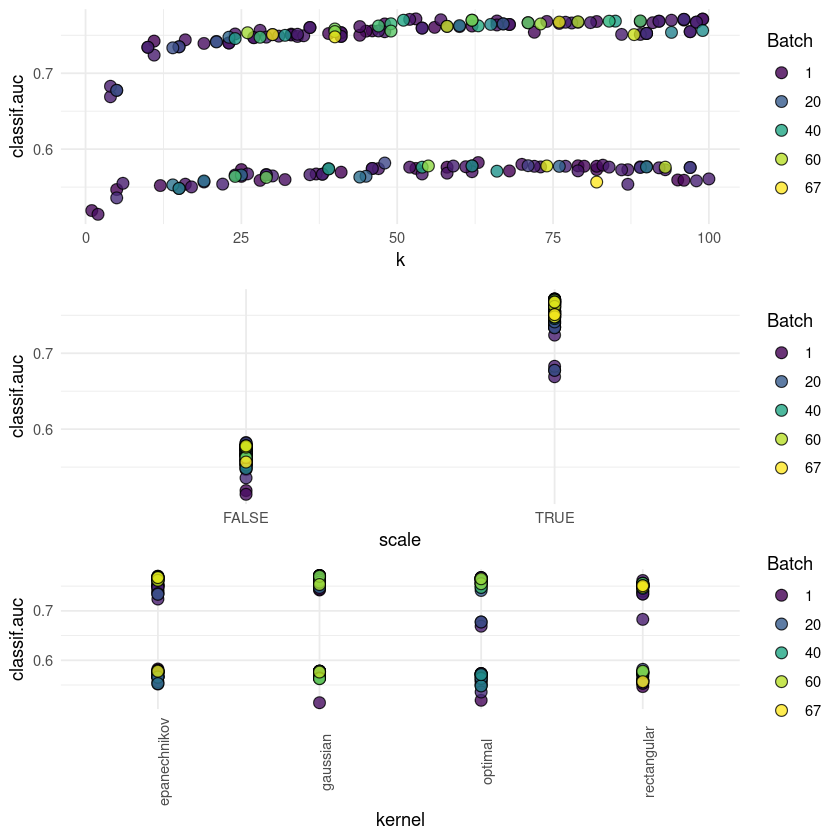

In [18]:
#| label: knn-viz

p <- autoplot(instance)
p[[3]] <- p[[3]] +
	theme(axis.text.x = element_text(angle = 90))
do.call(grid.arrange, c(p, list(ncol = 1)))

In [20]:
#| label: knn-final

optimal_config <- instance$result_learner_param_vals
lrn_knn$param_set$values <- optimal_config
lrn_knn$train(task_train)
prediction <- lrn_knn$predict(task_test)
prediction$score(msr("classif.auc"))

classif.auc 
  0.7813187

Plug in custom performance metric (AUC needs the learner to output probabilities):

In [10]:
# #| label: 1-d
# #| output: false
# lrn_knn <- lrn("classif.kknn", predict_type = "prob")
# instance_auc <- TuningInstanceSingleCrit$new(
#   task = task_train,
#   learner = lrn_knn,
#   resampling = resampling,
#   terminator = terminator,
#   search_space = search_space,
#   measure = msr("classif.auc")
# )
# set.seed(123)
# optimizer$optimize(instance_auc)

We can make convenient use of the autoplot functions in `mlr3`:

In [11]:
# #| label: 1-e
# library(mlr3viz)
# library(ggplot2)
# print(autoplot(instance_auc)) +
#   theme(axis.text.x = element_text(angle = 90))

Increasing $k$ initially leads to an improvement that plateaus after around 50 neighbors. Scaling the variables also boosts performance. The choice of the kernel, on the other hand, does not seem to have much impact.

Obviously, the interpretability of these plots is limited: we only see *marginal* effects of individual hyperparameters. The fact that they really interact with each other contributes substantially to the difficulty of the tuning problem. We can clearly see this in the plot for $k$, where we have two quite distinct patterns corresponding to different values of `scale`.


Tuning $k$ on log-scale requires a modification of the search space. For this, we need to transform the boundaries of the search interval and undo the transformation afterwards via `exp` (plus a rounding operation to ensure $k$ remains an integer number):

In [12]:
# #| label: 1-f
# #| output: false
# search_space = ps(
#   "k" = p_dbl(log(1), log(100)),
#   scale = p_lgl(),
#   kernel = p_fct(c("rectangular", "epanechnikov", "gaussian", "optimal")),
#   .extra_trafo = function(x, param_set) {
#     x$k = round(exp(x$k))
#     return(x)
#   }
# )
# instance_auc <- TuningInstanceSingleCrit$new(
#   task = task_train,
#   learner = lrn_knn,
#   resampling = resampling,
#   terminator = terminator,
#   search_space = search_space,
#   measure = msr("classif.auc")
# )

# set.seed(123)
# optimizer$optimize(instance_auc)